The Gurney flap is a small plate attached to or near the trailing edge of an airfoil, perpendicular to the flow on the pressure side.
Being counterintuitive to the idea of a streamlined body, the Gurney flap was invented more or less accidentally by race car driver Dan Gurney.

There are two basic (and somewhat overlapping) explanations for the lift-enhancing effect:

- The flap effectively increases camber [1], decelerating flow on the pressure side and accelerating flow on the suction side.
- The flap decelerates the flow on the pressure side right until the edge and leads to a pressure difference between suction and pressure side which in turn leads to an increased circulation [2].

However, the flow is rather complex and includes unsteady vortex-shedding[3] at the trailing edge.

To model the effects of a Gurney flap with viiflow, a single virtual displacement element is used depending on the position of the Gurney flap. 
The effect of Gurney flap position and height is analyzed and compared to the experimental results.
As far as the author knows, this is the first numerical analysis of Gurney flaps using a panel method.
The possibility of modeling the effect of a Gurney flap using a change in the Kutta condition of a panel method has been proposed in [2], but no function that correlates the Kutta condition (or a step in pressure) to the Gurney flap height is given.

The effect of Gurney flaps on the lift of an airfoil are surprisingly well predicted with viiflow.
This does not hold for the drag, though.
The drag increase for Gurney flaps that are not at the trailing edge can be computed with similar accuracy compared to a fully-turbulent RANS solution, but the coefficients were significantly overpredicted. 
For Gurney flaps right at the trailing edge, the drag cannot be computed using the wake boundary layer at this point, and the additional drag due to the Gurney flap is estimated using the local pressure at the flap.


## Experiments
The most comprehensive experimental analysis to date on an airfoil can be found in [7] where the S903 airfoil has been analyzed.
The coordinates of the airfoil can be found in [8], the paneling has been increased near the trailing edge.
Gurney flap position, height and influence of transition location have been evaluated.
In [4] some of these experimental results are compared with computational results with a fully-turbulent RANS solver. 
A note on these experimental results: the legend in the drag polar plot in [7], Fig. 6, is wrong.
Here, the plots have been changed assuming decreasing drag at higher lift coefficients with decreasing chord position. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
os.environ["OMP_NUM_THREADS"] = "1"

colors = ['k','k','k','k','k','k','k','k','k']
marks = ['o','^','v','<','>','d','^','^','^']

## Results
In all cases, viiflow accurately predicts the increase in lift and change in maximum lift.
The drag coefficient is less accurately predicted.

Where the Gurney flap is right at the trailing edge, the increase in drag is invisible to viiflow without further modifications.
In viiflow, the drag is calculated using the Squire-Young formula using the wake boundary layer development.
The wake boundary layer development depends on its initialization at the trailing edge, which is done by adding the momentum and displacement thickness of suction and pressure side and a weighted average of the shear-stress.
At this point, the modeling of the flow at the trailing edge is insufficient to describe the development of the wake behind a Gurney flap. 
However, the increase in drag seems to be largely dependent on the pressure difference at the Gurney flap [6].
Adding the pressure afterwards to the drag coefficient markedly improves the drag prediction.
In fact, the resulting polar matches the experiments better than the results of a Gurney flap at .9c or .95c.

If the transition is forced early on, the increase in drag matches the results of the RANS calculations better, though still with a significant drag bucket at low AOA. 
Without forced transition, the results do not get closer to the experimental results but vary significantly over the lift coefficient.
Both computational methods overpredict the increase in drag.

In [2]:
# We go through the experiments using the list below,
# using hgv, the vector of gurney flap heights
# and using pchord, the position of the gurney flap
N = 180
AF = vft.repanel(vft.read_selig("S903RF.dat"),int(N),REFLIMS=[1.0,1.0,0.8,1.0],KAPFAC=.5,REFVAL=3,LEFAC=5,TEFAC = .5)

# Virtual displacement
hgv = np.asarray([0.0,0.005,0.01,0.02,0.02,0.02,0.02,0,0.01])
pchord = [1,1,1,1,.95,.9,.9,.9,-1.0]
forced = np.asarray([0,0,0,0,0,0,1,1,0])

pol = []
AOARANGE = []

AOARANGE.append(np.arange(4.5,-13,-0.5))
AOARANGE.append(np.arange(5,18,0.5))

# Go over experiment setup
for i in range(len(hgv)):
#for i in range(4):
    hg = hgv[i] 
    pc = pchord[i]

    # Gurney flap displacement
    vd = 0*AF[0,:]
    if pc>=1.0:
        index_gf = N-1
        index_gfp = N-2
    elif pc<=-1.0:
        index_gf = 0
        index_gfp = 1
    else:
        for k in range(1,AF.shape[1]):
            if AF[0,-k]<pc:
                index_gf = N-k
                index_gfp = N-k-1
                break
    vd[index_gf] = hg


    # Solver Setup
    RE = 1.0e6
    AOA0 = AOARANGE[0]
    # Not sure why the authors only state "Mach less than 0.2", with the chord length and RE of 1e6 it should be 0.1.
    Mach = 0.1 
    # Ncrit = 8 is a better fit to the end of the drag bucket for the non-Gurney airfoil
    Ncrit = 8 
    
    s = vf.setup(Re=RE,Ma = Mach,Ncrit=Ncrit) 
    s.IterateWakes = False
    s.Itermax = 200
    s.Silent = True
    # Use incompressible boundary layer calculation.
    s.IncompressibleBL = 1
    s.StepsizeLimit = 0.1 # Restricting the stepsize is beneficial here for some AOA
    s.ShearLagType = 1 # Better fit with RFOIL-type shear lag equation

    alv = []
    clv = []
    cdv = []
    cdvg = []
    cdvg2 = []

    for j in range(2): # aoa up and down
        
        init = True
        
        for alpha in AOARANGE[j]:
            s.Alpha = alpha
            s.Ncrit = Ncrit
            
            if init:
                # Set-up and initialize based on inviscid panel solution
                (p,bl,x) = vf.init(AF,s)
                x[p.foils[0].N::p.foils[0].N+p.wakes[0].N-1]+=0.03#2*vd[-1]
                xn = x.copy()
                
                # Trigger transition a bit upstream of the GF
                if hg>0:
                    if pc>0:
                        xtrans = p.foils[0].X[0,index_gf]-0.001
                        vf.set_forced_transition(bl,p,[],[xtrans])
                    else:
                        xtrans = p.foils[0].X[0,index_gf]-0.001
                        vf.set_forced_transition(bl,p,[xtrans],[])

                # For the forced transition comparison use values near leading edge
                if forced[i]:
                    vf.set_forced_transition(bl,p,[.05],[.05])
                init = False

            res = None
            grad = None
            [xn,flag,res,grad,_] = vf.iter(xn,bl,p,s,res,grad,[vd])
            # Plot geometry

            nres=np.sqrt(np.dot(res.T,res))

            if flag>0:
                # Add to end or start of polar list
                if j == 1:pos = len(alv)
                else: pos = 0
                
                # Add pressure at gf. cp = 1-ue²/2
                # cp_before: 1-0, cpafter: 1-ue²/2, cd: cp_before-cp_after
                ue_gf = bl[0].bl_fl.nodes[index_gf].ue
                ue_gfp = bl[0].bl_fl.nodes[index_gfp].ue
                cdvg.insert(pos,hg*(0.5*ue_gf**2))
                cdvg2.insert(pos,hg*(0.5*(ue_gfp**2)))

                alv.insert(pos,alpha)
                clv.insert(pos,p.CL)
                cdv.insert(pos,bl[0].CD)
            else:
                init = True

    pol.append({'CL': np.asarray(clv), 'CD': np.asarray(cdv), 'CDg':np.asarray(cdvg),'CDg2':np.asarray(cdvg2), 'hg': hg, 'al': np.asarray(alv)})


 xi=0.969455,delta=0.000000,theta=0.000000,ue=311843.151544,typ=laminar,
 res=[15.384,-21.6278,3.30441e-05]
 dx=[-1.39548e-08,-271060,-3.76024e-05]
 x=[6.78739e-09,311843,1.05877] 
 lam=0.121596 H=2.085115 HS=1.646687 US=0.000000.

 xi=0.969455,delta=0.000000,theta=0.000000,ue=311843.151540,typ=laminar,
 res=[15.384,-21.6278,-4.35983e-06]
 dx=[-1.39548e-08,-271060,4.97924e-06]
 x=[6.78739e-09,311843,1.05873] 
 lam=0.121596 H=2.085115 HS=1.646687 US=0.000000.

 xi=0.969463,delta=0.000000,theta=0.000000,ue=163053.751584,typ=laminar,
 res=[14.0219,-20.9666,4.85171e-09]
 dx=[-1.87962e-08,-145552,1.59211e-08]
 x=[9.33449e-09,163054,1.05872] 
 lam=0.124154 H=2.122608 HS=1.639548 US=0.000000.

 xi=0.969463,delta=0.000000,theta=0.000000,ue=163053.751584,typ=laminar,
 res=[14.0219,-20.9666,4.85171e-09]
 dx=[-1.87962e-08,-145552,1.59211e-08]
 x=[9.33449e-09,163054,1.05872] 
 lam=0.124154 H=2.122608 HS=1.639548 US=0.000000.

 xi=0.969476,delta=0.000000,theta=0.000000,ue=80567.703663,typ=laminar,


 xi=0.973304,delta=0.000000,theta=0.000000,ue=3583910305.438458,typ=laminar,
 res=[17.7788,-27.9837,-2.1736e+06]
 dx=[1.75699e-11,3.69472e+08,2.44552e+06]
 x=[5.43243e-11,3.58391e+09,1.26022e+06] 
 lam=0.515317 H=1.829972 HS=1.705865 US=0.000000.

 xi=0.973304,delta=0.000000,theta=0.000000,ue=4062896064.249773,typ=laminar,
 res=[25.31,-29.5208,-17314.4]
 dx=[2.49967e-11,1.91883e+08,45572.1]
 x=[5.60974e-11,4.0629e+09,269527] 
 lam=0.374033 H=1.772132 HS=1.722231 US=0.000000.

 xi=0.973314,delta=0.000000,theta=0.000000,ue=3465604147.118704,typ=laminar,
 res=[16.7804,-27.6015,-1.54782e+06]
 dx=[1.26679e-11,7.20601e+06,2.60624e+06]
 x=[5.00215e-11,3.4656e+09,1.96484e+06] 
 lam=0.658114 H=1.963220 HS=1.672509 US=0.000000.

 xi=0.974242,delta=0.000000,theta=0.000000,ue=3503589650.575226,typ=laminar,
 res=[17.4012,-24.2788,943343]
 dx=[2.27858e-11,4.24085e+08,2.15868e+06]
 x=[5.97443e-11,3.50359e+09,943344] 
 lam=0.436999 H=1.742428 HS=1.731121 US=0.000000.

 xi=0.974242,delta=0.000000,theta

 xi=0.974725,delta=0.000000,theta=0.000000,ue=14467631112551517083957985280.000000,typ=turbulent,
 res=[-1083.57,555.343,-6.93602e-05]
 dx=[4.29097e-14,4.26744e+28,-3.54402e-11]
 x=[2.52381e-12,1.44676e+28,3.74144e-12] 
 lam=0.026393 H=2.027161 HS=1.570218 US=0.305815.

 xi=0.974756,delta=0.000000,theta=0.000000,ue=2352711742406.483887,typ=laminar,
 res=[16.2242,-35.9946,-3.40248e+07]
 dx=[-1.22116e-12,-1.2495e+12,-4.05215e+06]
 x=[1.34596e-12,2.35271e+12,9.27144e+07] 
 lam=0.275551 H=2.280678 HS=1.613121 US=0.000000.

 xi=0.974756,delta=0.000000,theta=0.000000,ue=2352711742406.483887,typ=laminar,
 res=[16.2242,-35.9946,-3.40248e+07]
 dx=[-1.22116e-12,-1.2495e+12,-4.05215e+06]
 x=[1.34596e-12,2.35271e+12,9.27144e+07] 
 lam=0.275551 H=2.280678 HS=1.613121 US=0.000000.

 xi=0.974756,delta=0.000000,theta=0.000000,ue=1222030812405.373779,typ=laminar,
 res=[16.5494,-36.9105,-2.25566e+07]
 dx=[-2.12915e-12,-8.1261e+11,-149811]
 x=[1.86601e-12,1.22203e+12,6.88153e+07] 
 lam=0.219103 H=2.30308

 xi=0.974817,delta=0.000000,theta=0.000000,ue=1044293989810.624512,typ=laminar,
 res=[11.4285,-22.3257,-3.48256e+07]
 dx=[-1.08299e-12,-2.51217e+11,-4.10968e+07]
 x=[2.36732e-12,1.04429e+12,3.81241e+07] 
 lam=0.546475 H=2.057954 HS=1.652087 US=0.000000.

 xi=0.974817,delta=0.000000,theta=0.000000,ue=1044293989810.624512,typ=laminar,
 res=[11.4285,-22.3257,-3.48256e+07]
 dx=[-1.08299e-12,-2.51217e+11,-4.10968e+07]
 x=[2.36732e-12,1.04429e+12,3.81241e+07] 
 lam=0.546475 H=2.057954 HS=1.652087 US=0.000000.

 xi=0.974817,delta=0.000000,theta=0.000000,ue=8667539433367559574938189824.000000,typ=turbulent,
 res=[-946.396,480.724,-7.01217e-05]
 dx=[6.46451e-14,2.78198e+28,-3.73289e-11]
 x=[3.39781e-12,8.66754e+27,3.74144e-12] 
 lam=0.025057 H=2.007340 HS=1.573687 US=0.311108.

 xi=0.974844,delta=0.000000,theta=0.000000,ue=1666292511581.522217,typ=laminar,
 res=[12.5444,-24.6264,-4.49568e+07]
 dx=[9.49621e-13,3.88259e+11,2.59248e+07]
 x=[2.44905e-12,1.66629e+12,4.57008e+07] 
 lam=0.429830 H=1.6

 xi=0.974986,delta=0.000000,theta=0.000000,ue=3118777080026.341797,typ=laminar,
 res=[7.79583,-17.5829,-8.68184e+06]
 dx=[2.35999e-13,3.04215e+11,1.16492e+07]
 x=[1.49136e-12,3.11878e+12,1.12295e+08] 
 lam=1.000000 H=1.889388 HS=1.690277 US=0.000000.

 xi=0.974986,delta=0.000000,theta=0.000000,ue=3118777080026.341797,typ=laminar,
 res=[7.79583,-17.5829,-8.68184e+06]
 dx=[2.35999e-13,3.04215e+11,1.16492e+07]
 x=[1.49136e-12,3.11878e+12,1.12295e+08] 
 lam=1.000000 H=1.889388 HS=1.690277 US=0.000000.

 xi=0.974986,delta=0.000000,theta=0.000000,ue=1553197556474.074951,typ=laminar,
 res=[10.0624,-20.9481,-3.80377e+07]
 dx=[-7.42977e-13,-3.33392e+11,-3.52997e+07]
 x=[1.89909e-12,1.5532e+12,5.27125e+07] 
 lam=0.639014 H=2.077233 HS=1.648234 US=0.000000.

 xi=0.974986,delta=0.000000,theta=0.000000,ue=1553197556474.074951,typ=laminar,
 res=[10.0624,-20.9481,-3.80377e+07]
 dx=[-7.42977e-13,-3.33392e+11,-3.52997e+07]
 x=[1.89909e-12,1.5532e+12,5.27125e+07] 
 lam=0.639014 H=2.077233 HS=1.648234 US

 xi=1.030531,delta=0.006520,theta=0.000080,ue=0.988818,typ=wake,
 res=[0.085018,-0.00462324,4.19025e-09]
 dx=[-3.4344e-07,0.000553804,3.88244e-06]
 x=[7.97419e-05,0.988818,0.0332168] 
 lam=1.000000 H=1.529573 HS=1.760563 US=0.513085.

 xi=1.961004,delta=0.000000,theta=0.000000,ue=30.236848,typ=wake,
 res=[0.906863,-8.78615e+10,-0.000218771]
 dx=[-3.25372e-10,-72.1573,0.152229]
 x=[7.39088e-11,30.2368,0.0955587] 
 lam=0.056788 H=2.496030 HS=1.580398 US=0.219577.

 xi=1.961013,delta=0.000000,theta=0.000000,ue=52.446061,typ=wake,
 res=[0.895758,-7.36973e+11,-0.000170421]
 dx=[7.54667e-11,150.033,-0.216987]
 x=[1.73128e-11,52.4461,0.0859927] 
 lam=0.038235 H=1.886623 HS=1.669713 US=0.362154.

 xi=1.958648,delta=0.000285,theta=0.000257,ue=0.694414,typ=wake,
 res=[-0.00643161,0.0359405,7.07412e-05]
 dx=[3.95666e-05,-0.0314173,-0.00695129]
 x=[0.000257189,0.694414,0.011593] 
 lam=0.416937 H=1.110022 HS=1.934999 US=0.851962.

 xi=1.786150,delta=0.000145,theta=0.000047,ue=1.408741,typ=wake,
 re

 xi=1.732918,delta=0.000248,theta=0.000205,ue=0.908420,typ=wake,
 res=[-7.93877e-05,0.0120141,4.50389e-07]
 dx=[2.26761e-06,-0.00303762,-0.000410212]
 x=[0.000205356,0.90842,0.0167142] 
 lam=1.000000 H=1.206657 HS=1.885756 US=0.748322.

 xi=1.028623,delta=0.006482,theta=0.000073,ue=0.978464,typ=wake,
 res=[-0.288464,0.792982,7.27018e-06]
 dx=[2.87447e-05,0.000607276,0.00154437]
 x=[7.25529e-05,0.978464,0.0277468] 
 lam=0.420674 H=1.155208 HS=1.911146 US=0.800891.

 xi=1.732932,delta=0.000253,theta=0.000209,ue=0.902766,typ=wake,
 res=[-4.94168e-05,0.00921331,3.5988e-07]
 dx=[1.81844e-06,-0.00238384,-0.000377745]
 x=[0.000208823,0.902766,0.016865] 
 lam=1.000000 H=1.213608 HS=1.882462 US=0.741633.

 xi=1.732937,delta=0.000254,theta=0.000209,ue=0.902491,typ=wake,
 res=[-2.46094e-05,0.00670931,1.79619e-07]
 dx=[1.28445e-06,-0.00168114,-0.000266252]
 x=[0.000208679,0.902491,0.0169051] 
 lam=1.000000 H=1.215206 HS=1.881709 US=0.740108.

 xi=1.732938,delta=0.000254,theta=0.000208,ue=0.903783,

 xi=1.960045,delta=0.000287,theta=0.000272,ue=0.362903,typ=wake,
 res=[-0.697997,-0.884627,0.00246623]
 dx=[0.00193421,-0.930273,-0.0286891]
 x=[0.000271533,0.362903,0.00203516] 
 lam=0.014265 H=1.057935 HS=1.964473 US=0.917429.

 xi=1.960053,delta=0.000284,theta=0.000268,ue=0.362225,typ=wake,
 res=[-0.721678,-0.867322,0.00254444]
 dx=[0.00234462,-1.15527,-0.0322922]
 x=[0.000268235,0.362225,0.00186317] 
 lam=0.011623 H=1.057918 HS=1.964483 US=0.917452.

 xi=1.960079,delta=0.000280,theta=0.000265,ue=0.361514,typ=wake,
 res=[-0.74711,-0.848988,0.00263132]
 dx=[0.00304035,-1.53657,-0.0384349]
 x=[0.000264972,0.361514,0.00168547] 
 lam=0.008855 H=1.057925 HS=1.964478 US=0.917443.

 xi=1.960086,delta=0.000198,theta=0.000171,ue=0.660798,typ=wake,
 res=[-0.0353645,-0.621674,0.00047968]
 dx=[-0.000350527,0.391882,0.0876554]
 x=[0.000170871,0.660798,0.0160703] 
 lam=0.030556 H=1.157563 HS=1.909943 US=0.798361.

 xi=1.035612,delta=0.025114,theta=0.002244,ue=1.055775,typ=wake,
 res=[-0.0105823,0

 xi=0.005809,delta=0.000045,theta=0.000025,ue=0.708184,typ=laminar,
 res=[0.0714849,-0.156311,-6.77626e-21]
 dx=[2.93359e-06,-0.000969083,-5.51171e-06]
 x=[2.49804e-05,0.708184,4.98051e-05] 
 lam=1.000000 H=1.781480 HS=1.719503 US=0.000000.

 xi=0.005939,delta=0.000042,theta=0.000022,ue=0.771191,typ=laminar,
 res=[0.0991936,-0.213183,0]
 dx=[2.87597e-06,0.00124017,-4.87284e-06]
 x=[2.23673e-05,0.771191,4.98051e-05] 
 lam=1.000000 H=1.895190 HS=1.688818 US=0.000000.

 xi=0.006057,delta=0.000041,theta=0.000022,ue=0.837865,typ=laminar,
 res=[0.170751,-0.219236,5.44764e-06]
 dx=[-7.31439e-06,0.0110828,7.31439e-06]
 x=[2.17906e-05,0.837865,5.52527e-05] 
 lam=0.744783 H=1.868123 HS=1.695719 US=0.000000.

 xi=0.006189,delta=0.000039,theta=0.000021,ue=0.899067,typ=laminar,
 res=[0.181774,-0.214846,5.29779e-06]
 dx=[-7.83723e-06,0.0156434,7.83723e-06]
 x=[2.11912e-05,0.899067,5.51028e-05] 
 lam=0.675978 H=1.848687 HS=1.700825 US=0.000000.

 xi=0.006313,delta=0.000038,theta=0.000018,ue=0.936879,

 xi=0.006029,delta=0.000035,theta=0.000021,ue=1.014032,typ=laminar,
 res=[0.0789985,-0.176225,0]
 dx=[2.67298e-06,-0.00219002,-4.05103e-06]
 x=[2.13589e-05,1.01403,4.98051e-05] 
 lam=1.000000 H=1.637096 HS=1.765519 US=0.000000.

 xi=0.005962,delta=0.000035,theta=0.000019,ue=0.992638,typ=laminar,
 res=[0.0672222,-0.144882,0]
 dx=[2.06813e-06,0.00299731,-3.8498e-06]
 x=[1.9457e-05,0.992638,4.98051e-05] 
 lam=1.000000 H=1.811333 HS=1.711006 US=0.000000.

 xi=0.005986,delta=0.000035,theta=0.000016,ue=1.016374,typ=laminar,
 res=[0.247003,-0.543962,4.02037e-06]
 dx=[-8.02809e-06,-0.0142128,8.02809e-06]
 x=[1.60815e-05,1.01637,5.38254e-05] 
 lam=0.500789 H=2.148127 HS=1.634889 US=0.000000.

 xi=0.006036,delta=0.000034,theta=0.000016,ue=1.038035,typ=laminar,
 res=[0.242535,-0.534729,3.98428e-06]
 dx=[-7.04302e-06,-0.0131134,7.04302e-06]
 x=[1.59371e-05,1.03803,5.37893e-05] 
 lam=0.565706 H=2.141399 HS=1.636102 US=0.000000.

 xi=0.005974,delta=0.000034,theta=0.000018,ue=1.024543,typ=laminar,
 r

 xi=0.005999,delta=0.000032,theta=0.000020,ue=1.117158,typ=laminar,
 res=[0.0962035,-0.213173,0]
 dx=[2.64764e-06,0.00205831,-3.47219e-06]
 x=[1.99111e-05,1.11716,4.98051e-05] 
 lam=1.000000 H=1.615635 HS=1.773115 US=0.000000.

 xi=0.006035,delta=0.000032,theta=0.000017,ue=1.124648,typ=laminar,
 res=[0.117283,-0.244706,3.12784e-06]
 dx=[-3.12784e-06,-0.00760801,3.12784e-06]
 x=[1.6534e-05,1.12465,5.29329e-05] 
 lam=1.000000 H=1.930556 HS=1.680160 US=0.000000.

 xi=0.005985,delta=0.000032,theta=0.000018,ue=1.111730,typ=laminar,
 res=[0.068466,-0.149919,0]
 dx=[1.94088e-06,0.00503502,-3.21429e-06]
 x=[1.82743e-05,1.11173,4.98051e-05] 
 lam=1.000000 H=1.758651 HS=1.726224 US=0.000000.

 xi=0.006015,delta=0.000032,theta=0.000016,ue=1.120828,typ=laminar,
 res=[0.136774,-0.294595,3.23929e-06]
 dx=[-3.23929e-06,-0.00888541,3.23929e-06]
 x=[1.61407e-05,1.12083,5.30443e-05] 
 lam=1.000000 H=1.975806 HS=1.669647 US=0.000000.

 xi=0.006060,delta=0.000032,theta=0.000015,ue=1.134125,typ=laminar,
 r

 xi=0.006012,delta=0.000031,theta=0.000017,ue=1.169163,typ=laminar,
 res=[0.0833434,-0.178349,0]
 dx=[1.85164e-06,0.00728847,-3.44191e-06]
 x=[1.68297e-05,1.16916,4.98051e-05] 
 lam=1.000000 H=1.825711 HS=1.707029 US=0.000000.

 xi=0.006049,delta=0.000031,theta=0.000016,ue=1.181579,typ=laminar,
 res=[0.103538,-0.218974,0]
 dx=[1.90625e-06,0.00850183,-3.56765e-06]
 x=[1.61768e-05,1.18158,4.98051e-05] 
 lam=1.000000 H=1.887730 HS=1.690696 US=0.000000.

 xi=0.006003,delta=0.000031,theta=0.000021,ue=1.183027,typ=laminar,
 res=[0.197897,-0.384407,0]
 dx=[1.27626e-05,0.0491025,-0]
 x=[2.06846e-05,1.18303,4.98051e-05] 
 lam=0.270120 H=1.484366 HS=1.824396 US=0.000000.

 xi=0.005994,delta=0.000031,theta=0.000017,ue=1.174273,typ=laminar,
 res=[0.0775528,-0.168452,0]
 dx=[1.86647e-06,0.00706801,-3.19302e-06]
 x=[1.71845e-05,1.17427,4.98051e-05] 
 lam=1.000000 H=1.779315 HS=1.720132 US=0.000000.

 xi=0.006011,delta=0.000030,theta=0.000014,ue=1.180078,typ=laminar,
 res=[0.235095,-0.517104,3.59949e

 xi=0.006019,delta=0.000030,theta=0.000018,ue=1.229500,typ=laminar,
 res=[0.0997075,-0.222511,0]
 dx=[2.2657e-06,0.00772498,-3.0186e-06]
 x=[1.78037e-05,1.2295,4.98051e-05] 
 lam=1.000000 H=1.656991 HS=1.758662 US=0.000000.

 xi=0.006047,delta=0.000029,theta=0.000019,ue=1.245408,typ=laminar,
 res=[0.132797,-0.293514,0]
 dx=[2.76082e-06,-0.00420227,-3.93576e-06]
 x=[1.85039e-05,1.24541,4.98051e-05] 
 lam=1.000000 H=1.585621 HS=1.784092 US=0.000000.

 xi=0.006010,delta=0.000029,theta=0.000020,ue=1.239789,typ=laminar,
 res=[0.226782,-0.43354,0]
 dx=[0.000583741,2.87038,-0]
 x=[2.0026e-05,1.23979,4.98051e-05] 
 lam=0.005718 H=1.472344 HS=1.829537 US=0.000000.

 xi=0.006035,delta=0.000029,theta=0.000015,ue=1.226151,typ=laminar,
 res=[0.161455,-0.349184,3.08839e-06]
 dx=[-3.08839e-06,-0.0144516,3.08839e-06]
 x=[1.47223e-05,1.22615,5.28934e-05] 
 lam=1.000000 H=1.991915 HS=1.666053 US=0.000000.

 xi=0.006069,delta=0.000029,theta=0.000014,ue=1.234408,typ=laminar,
 res=[0.242562,-0.534339,3.469

 xi=0.013047,delta=0.000057,theta=0.000035,ue=0.590836,typ=laminar,
 res=[0.307026,-0.575986,4.26812e-06]
 dx=[9.6406e-06,-0.00375546,-1.0587e-05]
 x=[3.45241e-05,0.590836,0.000129701] 
 lam=0.596853 H=1.661088 HS=1.757272 US=0.000000.

 xi=0.013194,delta=0.000057,theta=0.000033,ue=0.580532,typ=laminar,
 res=[0.244889,-0.510103,2.17947e-06]
 dx=[7.18152e-06,-0.000213553,-9.51438e-06]
 x=[3.32186e-05,0.580532,0.000127613] 
 lam=0.770928 H=1.724356 HS=1.736698 US=0.000000.

 xi=0.012982,delta=0.000057,theta=0.000031,ue=0.571953,typ=laminar,
 res=[0.217404,-0.476566,6.07496e-07]
 dx=[5.6364e-06,0.00312972,-7.44228e-06]
 x=[3.10579e-05,0.571953,0.000126041] 
 lam=0.918372 H=1.849377 HS=1.700642 US=0.000000.

 xi=0.013229,delta=0.000058,theta=0.000033,ue=0.574294,typ=laminar,
 res=[0.239272,-0.502261,1.99939e-06]
 dx=[7.05511e-06,0.000141291,-9.35664e-06]
 x=[3.32852e-05,0.574294,0.000127433] 
 lam=0.786313 H=1.729877 HS=1.734981 US=0.000000.

 xi=0.013240,delta=0.000057,theta=0.000030,ue=0

 xi=0.025135,delta=0.000006,theta=0.000003,ue=13.723327,typ=laminar,
 res=[2.69386,-3.77761,2.1684e-06]
 dx=[-7.5684e-06,-7.42915,5.96275e-06]
 x=[2.85712e-06,13.7233,7.66982] 
 lam=0.094377 H=2.143294 HS=1.635759 US=0.000000.

 xi=0.025121,delta=0.000004,theta=0.000002,ue=27.993497,typ=laminar,
 res=[3.51834,-4.7252,1.19929e-06]
 dx=[-4.00161e-06,-13.4304,3.15485e-06]
 x=[1.78863e-06,27.9935,7.64226] 
 lam=0.111745 H=2.054712 HS=1.652744 US=0.000000.

 xi=0.025110,delta=0.000002,theta=0.000001,ue=58.815251,typ=laminar,
 res=[3.44755,-5.57569,3.97863e-07]
 dx=[5.2231e-07,7.04591,-6.48356e-07]
 x=[1.21077e-06,58.8153,7.62688] 
 lam=0.386352 H=1.821209 HS=1.708267 US=0.000000.

 xi=0.025162,delta=0.000001,theta=0.000001,ue=126.829456,typ=laminar,
 res=[4.59251,-7.04473,2.84446e-07]
 dx=[-1.26487e-06,-53.7197,1.12651e-06]
 x=[6.56117e-07,126.829,7.67481] 
 lam=0.129681 H=2.016475 HS=1.660716 US=0.000000.

 xi=0.025138,delta=0.000001,theta=0.000000,ue=272.239876,typ=laminar,
 res=[6.17829,

 xi=0.024997,delta=0.000000,theta=0.000000,ue=18157.724464,typ=laminar,
 res=[7.21741,-13.9655,1.23027e-08]
 dx=[-3.59725e-08,-11303.2,3.00311e-08]
 x=[3.04794e-08,18157.7,6.26924] 
 lam=0.211825 H=2.256183 HS=1.616852 US=0.000000.

 xi=0.025007,delta=0.000000,theta=0.000000,ue=51881.720806,typ=laminar,
 res=[8.37367,-14.4613,5.31358e-09]
 dx=[7.97405e-09,8045.9,-1.01047e-08]
 x=[2.26853e-08,51881.7,7.21941] 
 lam=0.474148 H=1.818813 HS=1.708928 US=0.000000.

 xi=0.025017,delta=0.000000,theta=0.000000,ue=23999.710041,typ=laminar,
 res=[10.1689,-19.5512,5.28379e-09]
 dx=[-1.35795e-07,-69065.2,-5.5336e-09]
 x=[2.45213e-08,23999.7,7.21384] 
 lam=0.045144 H=2.355882 HS=1.602427 US=0.000000.

 xi=0.025017,delta=0.000000,theta=0.000000,ue=16237.091267,typ=laminar,
 res=[6.45524,-11.2241,8.5955e-09]
 dx=[3.00923e-08,5653.48,-1.17128e-08]
 x=[4.80535e-08,16237.1,6.26037] 
 lam=0.266145 H=1.683063 HS=1.749936 US=0.000000.

 xi=0.025033,delta=0.000000,theta=0.000000,ue=37990.429182,typ=laminar,



 xi=0.024448,delta=0.000004,theta=0.000002,ue=20.623158,typ=laminar,
 res=[2.39937,-4.6284,4.10727e-07]
 dx=[-8.34266e-06,-29.7736,-4.33836e-07]
 x=[1.77753e-06,20.6232,6.50377] 
 lam=0.053266 H=2.329448 HS=1.606059 US=0.000000.

 xi=0.024432,delta=0.000006,theta=0.000003,ue=14.180566,typ=laminar,
 res=[1.7907,-2.84716,1.12655e-06]
 dx=[-4.00758e-06,-2.72537,3.52098e-06]
 x=[2.91355e-06,14.1806,6.5535] 
 lam=0.181752 H=1.989650 HS=1.666554 US=0.000000.

 xi=0.024480,delta=0.000008,theta=0.000004,ue=9.061560,typ=laminar,
 res=[1.65309,-2.92636,1.97766e-06]
 dx=[-8.6968e-06,-4.67989,7.48097e-06]
 x=[3.5426e-06,9.06156,6.58242] 
 lam=0.101836 H=2.247061 HS=1.618274 US=0.000000.

 xi=0.024849,delta=0.000011,theta=0.000005,ue=5.951513,typ=laminar,
 res=[1.36454,-2.32905,3.16351e-06]
 dx=[-1.49431e-05,-2.54658,1.28812e-05]
 x=[5.11184e-06,5.95151,6.64752] 
 lam=0.085522 H=2.226535 HS=1.621540 US=0.000000.

 xi=0.024918,delta=0.000007,theta=0.000003,ue=11.167713,typ=laminar,
 res=[2.05646,-3

 xi=0.929906,delta=0.000283,theta=0.000272,ue=2.015244,typ=turbulent,
 res=[-0.000634274,0.00578249,5.10249e-06]
 dx=[2.62047e-06,-0.00614278,5.08434e-05]
 x=[0.000272217,2.01524,0.047083] 
 lam=1.000000 H=1.039532 HS=1.973541 US=0.941559.

 xi=0.936591,delta=0.000034,theta=0.000033,ue=10.004451,typ=turbulent,
 res=[0.00608637,-0.00609667,-1.17368e-05]
 dx=[-3.38074e-07,0.0461318,3.12203e-05]
 x=[3.27832e-05,10.0045,0.0238222] 
 lam=1.000000 H=1.027173 HS=1.982680 US=0.959743.

 xi=0.944936,delta=0.000031,theta=0.000028,ue=11.065565,typ=turbulent,
 res=[-0.080624,0.0665985,7.47973e-06]
 dx=[3.03956e-06,-0.647205,-0.000957494]
 x=[2.76989e-05,11.0656,0.0219131] 
 lam=1.000000 H=1.103584 HS=1.937634 US=0.859257.

 xi=0.946642,delta=0.000029,theta=0.000026,ue=10.599495,typ=turbulent,
 res=[-0.00601719,0.00582095,2.30667e-06]
 dx=[2.26764e-07,-0.044264,-0.000108588]
 x=[2.64768e-05,10.5995,0.021038] 
 lam=1.000000 H=1.097360 HS=1.941267 US=0.866878.

 xi=0.952048,delta=0.000038,theta=0.000


 xi=0.076866,delta=0.000069,theta=0.000039,ue=1.438709,typ=turbulent,
 res=[0.260501,-0.556082,2.82723e-05]
 dx=[-2.04771e-05,0.0356681,0.0102362]
 x=[3.86597e-05,1.43871,0.0316381] 
 lam=0.471987 H=1.793626 HS=1.689795 US=0.394486.

 xi=0.077443,delta=0.000068,theta=0.000038,ue=1.461529,typ=turbulent,
 res=[0.250202,-0.573672,-8.74827e-06]
 dx=[-1.79279e-05,0.0238689,0.00927052]
 x=[3.76522e-05,1.46153,0.0317066] 
 lam=0.525052 H=1.811802 HS=1.685696 US=0.387849.

 xi=0.078446,delta=0.000067,theta=0.000036,ue=1.496810,typ=turbulent,
 res=[0.246604,-0.638714,-6.11933e-05]
 dx=[-1.46986e-05,-0.000419979,0.00822188]
 x=[3.56674e-05,1.49681,0.0321478] 
 lam=0.606648 H=1.868008 HS=1.673560 US=0.368314.

 xi=0.080014,delta=0.000065,theta=0.000035,ue=1.559676,typ=turbulent,
 res=[0.25432,-0.643624,-5.62062e-05]
 dx=[-1.45982e-05,-0.00169925,0.00843986]
 x=[3.48971e-05,1.55968,0.0318292] 
 lam=0.597625 H=1.860140 HS=1.675211 US=0.370962.

 xi=0.078677,delta=0.000066,theta=0.000034,ue=1.51192

 xi=0.080801,delta=0.000058,theta=0.000028,ue=1.750468,typ=turbulent,
 res=[0.37212,-1.03246,-0.000337872]
 dx=[-3.2055e-05,-0.0477733,0.0210367]
 x=[2.81449e-05,1.75047,0.0321063] 
 lam=0.219505 H=2.046278 HS=1.639925 US=0.314838.

 xi=0.080792,delta=0.000057,theta=0.000032,ue=1.776572,typ=turbulent,
 res=[0.260258,-0.635609,-6.58948e-05]
 dx=[-1.26144e-05,0.00375207,0.00788305]
 x=[3.15601e-05,1.77657,0.0294113] 
 lam=0.621826 H=1.816668 HS=1.684614 US=0.386100.

 xi=0.080794,delta=0.000057,theta=0.000031,ue=1.780182,typ=turbulent,
 res=[0.256437,-0.672385,-7.90358e-05]
 dx=[-1.13893e-05,-0.0127094,0.0074032]
 x=[3.08632e-05,1.78018,0.0297597] 
 lam=0.669974 H=1.849203 HS=1.677532 US=0.374689.

 xi=0.080825,delta=0.000057,theta=0.000029,ue=1.779674,typ=turbulent,
 res=[0.27898,-0.825057,-0.00020564]
 dx=[-1.18803e-05,-0.0201566,0.00783856]
 x=[2.91535e-05,1.77967,0.0309162] 
 lam=0.613483 H=1.946760 HS=1.657841 US=0.343227.

 xi=0.081588,delta=0.000057,theta=0.000032,ue=1.828886,typ=

 xi=0.080608,delta=0.000057,theta=0.000030,ue=1.761507,typ=turbulent,
 res=[0.255817,-0.725651,-0.000129868]
 dx=[-1.10908e-05,-0.0144521,0.00719227]
 x=[3.0377e-05,1.76151,0.0303371] 
 lam=0.684733 H=1.889178 HS=1.669192 US=0.361320.

 xi=0.080462,delta=0.000058,theta=0.000033,ue=1.782195,typ=turbulent,
 res=[0.305304,-0.595569,-2.55923e-06]
 dx=[-1.75915e-05,0.0386766,0.01047]
 x=[3.28267e-05,1.78219,0.0284721] 
 lam=0.453231 H=1.753999 HS=1.699042 US=0.409536.

 xi=0.080416,delta=0.000057,theta=0.000030,ue=1.750314,typ=turbulent,
 res=[0.261537,-0.764974,-0.000163666]
 dx=[-1.12014e-05,-0.0164201,0.00725531]
 x=[3.0003e-05,1.75031,0.0306306] 
 lam=0.669628 H=1.915639 HS=1.663881 US=0.352842.

 xi=0.080507,delta=0.000057,theta=0.000032,ue=1.788541,typ=turbulent,
 res=[0.268132,-0.623,-5.2402e-05]
 dx=[-1.32799e-05,0.00848612,0.00827238]
 x=[3.16906e-05,1.78854,0.0290369] 
 lam=0.585017 H=1.798156 HS=1.688765 US=0.392816.

 xi=0.080436,delta=0.000057,theta=0.000028,ue=1.764497,typ=tur

 xi=0.080629,delta=0.000058,theta=0.000029,ue=1.737449,typ=turbulent,
 res=[0.296794,-0.868839,-0.000239772]
 dx=[-1.40442e-05,-0.0215232,0.00909037]
 x=[2.9387e-05,1.73745,0.0314981] 
 lam=0.523117 H=1.974281 HS=1.652678 US=0.335029.

 xi=0.080509,delta=0.000058,theta=0.000041,ue=1.745236,typ=turbulent,
 res=[0.288537,-0.912974,-0.00018188]
 dx=[3.74583e-05,0.0347686,-0.0244207]
 x=[4.1106e-05,1.74524,0.0240017] 
 lam=0.182896 H=1.416595 HS=1.798577 US=0.580657.

 xi=0.080549,delta=0.000058,theta=0.000029,ue=1.736693,typ=turbulent,
 res=[0.298517,-0.873329,-0.000243823]
 dx=[-1.4192e-05,-0.021885,0.00918172]
 x=[2.93264e-05,1.73669,0.0314935] 
 lam=0.516602 H=1.976923 HS=1.652191 US=0.334257.

 xi=0.080585,delta=0.000058,theta=0.000029,ue=1.745241,typ=turbulent,
 res=[0.330171,-0.94494,-0.000288639]
 dx=[-1.83937e-05,-0.0290239,0.0119974]
 x=[2.87355e-05,1.74524,0.0317893] 
 lam=0.390561 H=2.009545 HS=1.646299 US=0.324921.

 xi=0.080622,delta=0.000058,theta=0.000029,ue=1.753457,typ=tu


 xi=0.080664,delta=0.000059,theta=0.000040,ue=1.717778,typ=turbulent,
 res=[0.274315,-0.788043,-8.01906e-05]
 dx=[1.19714e-05,-0.0197887,-0.00712914]
 x=[4.03464e-05,1.71778,0.0250932] 
 lam=0.561705 H=1.472820 HS=1.778985 US=0.545451.

 xi=0.080703,delta=0.000059,theta=0.000040,ue=1.722737,typ=turbulent,
 res=[0.23839,-0.744703,-0.000114899]
 dx=[9.71802e-06,-0.0119944,-0.00584025]
 x=[3.95069e-05,1.72274,0.0255208] 
 lam=0.677554 H=1.495612 HS=1.771430 US=0.532093.

 xi=0.080732,delta=0.000059,theta=0.000038,ue=1.728258,typ=turbulent,
 res=[0.207894,-0.680391,-0.000143494]
 dx=[7.80979e-06,-0.00483208,-0.00469422]
 x=[3.83925e-05,1.72826,0.0261349] 
 lam=0.819324 H=1.531572 HS=1.759938 US=0.511998.

 xi=0.080751,delta=0.000059,theta=0.000039,ue=1.741534,typ=turbulent,
 res=[0.242573,-0.754443,-0.000113563]
 dx=[9.80763e-06,-0.0121168,-0.00595578]
 x=[3.92275e-05,1.74153,0.0253619] 
 lam=0.666615 H=1.492808 HS=1.772348 US=0.533710.

 xi=0.080763,delta=0.000058,theta=0.000040,ue=1.756

Text(0.5, 0, 'CD')

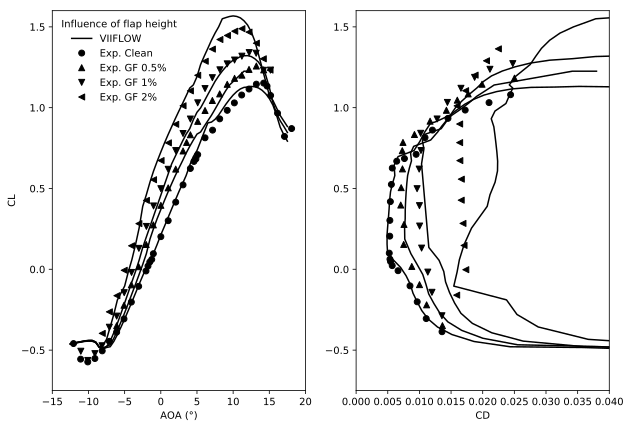

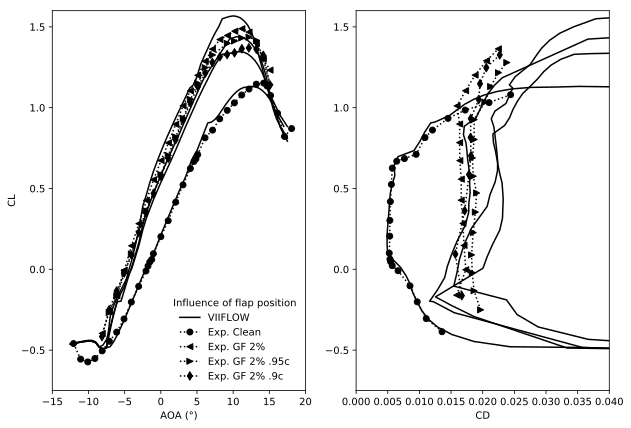

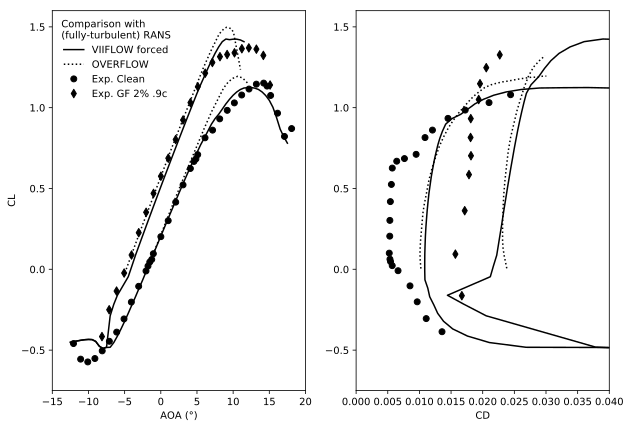

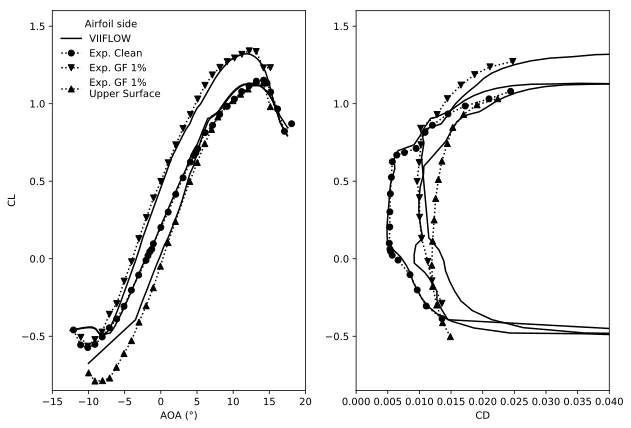

In [3]:
matplotlib.rcParams['figure.figsize'] = [10, 7] # Make plots bigger than default
fig,ax = plt.subplots(1,2)
cmap = plt.get_cmap("tab10")

# Part one, influence of height
namesVF = ['VIIFLOW',None,None,None,\
          None,None,\
          'VIIFLOW forced',None,\
          None]

linestyle_vf = ['-','-','-','-','-','-','-','-','-']

for k in range(4):
    ax[0].plot(pol[k]['al'],pol[k]['CL'],'-',color=colors[k],label = namesVF[k])
    ax[1].plot(pol[k]['CD']*1+1*(pol[k]['CDg']),pol[k]['CL'],color=colors[k])
    #ax[1].plot(pol[k]['CD']*1+1*(pol[k]['CDg2']),pol[k]['CL'],color='m')


namesEXP = ['Exp. Clean','Exp. GF 0.5%','Exp. GF 1%','Exp. GF 2%','Exp. GF 2% .95c',\
            'Exp. GF 2% .9c','Exp. GF 1%\nUpper Surface']
for k in range(4):
    Data = np.genfromtxt('S903GurneyCL.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[0].plot(Data.T[0],Data.T[1],'o',color = colors[k],label = namesEXP[k],marker=marks[k])
    Data = np.genfromtxt('S903GurneyPolar.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[1].plot(Data.T[0],Data.T[1],'o',color = colors[k],marker=marks[k])

ax[0].legend(frameon=False,title='Influence of flap height')
ax[0].set_xlim(-15,20)
ax[1].set_xlim(0,0.04)
ax[1].set_ylim(-.75,1.6)
ax[0].set_ylim(-.75,1.6)
ax[0].set_xlabel('AOA (°)')
ax[0].set_ylabel('CL')
ax[1].set_xlabel('CD')


# Part two, influence of chord position
fig,ax = plt.subplots(1,2)
kcol = 0
for k in [0,3,4,5]:
    ax[0].plot(pol[k]['al'],pol[k]['CL'],'-',color=colors[k],label = namesVF[k])
    if k>3: useg=0
    else: useg=1
    ax[1].plot(pol[k]['CD']*1+useg*pol[k]['CDg'],pol[k]['CL'],color=colors[k])
    #ax[1].plot(pol[k]['CD']*1+useg*pol[k]['CDg2'],pol[k]['CL'],color='m')
    kcol+=1

kcol = 0
for k in [0,3,4,5]:
    Data = np.genfromtxt('S903GurneyCL.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[0].plot(Data.T[0],Data.T[1],':o',color = colors[kcol],label = namesEXP[k],marker=marks[k])
    Data = np.genfromtxt('S903GurneyPolar.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[1].plot(Data.T[0],Data.T[1],':o',color = colors[kcol],marker=marks[k])
    kcol+=1

ax[0].legend(frameon=False,title = 'Influence of flap position')
ax[0].set_xlim(-15,20)
ax[1].set_xlim(0,0.04)
ax[1].set_ylim(-.75,1.6)
ax[0].set_ylim(-.75,1.6)
ax[0].set_xlabel('AOA (°)')
ax[0].set_ylabel('CL')
ax[1].set_xlabel('CD')


# Part three, comparison with fully-turbulent RANS
fig,ax = plt.subplots(1,2)
kcol = 0
for k in [6,7]:
    ax[0].plot(pol[k]['al'],pol[k]['CL'],'-',color=colors[kcol],label = namesVF[k],linestyle=linestyle_vf[k])
    if k>3: useg=0
    else: useg=1
    ax[1].plot(pol[k]['CD']*1+useg*pol[k]['CDg'],pol[k]['CL'],color=colors[kcol],linestyle=linestyle_vf[k])
    kcol+=1
    
# Add CFD results from thesis
names = ['Clean Exp.','OVERFLOW','GF Exp',None]
linestyle = ['o',':','o',':']
for k in [1,3]:
    Data = np.genfromtxt('GurneyS903Lift.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[0].plot(Data.T[0],Data.T[1],linestyle[k],color = colors[k],label = names[k])
    Data = np.genfromtxt('GurneyS903Polar.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[1].plot(Data.T[0],Data.T[1],linestyle[k],color = colors[k],label = names[k])    

kcol = 0
for k in [0,5]:
    Data = np.genfromtxt('S903GurneyCL.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[0].plot(Data.T[0],Data.T[1],'o',color = colors[kcol],label = namesEXP[k],marker=marks[k])
    Data = np.genfromtxt('S903GurneyPolar.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[1].plot(Data.T[0],Data.T[1],'o',color = colors[kcol],marker=marks[k])
    kcol+=1



ax[0].legend(frameon=False,title = 'Comparison with \n(fully-turbulent) RANS')
ax[0].set_xlim(-15,20)
ax[1].set_xlim(0,0.04)
ax[1].set_ylim(-.75,1.6)
ax[0].set_ylim(-.75,1.6)
ax[0].set_xlabel('AOA (°)')
ax[0].set_ylabel('CL')
ax[1].set_xlabel('CD')


# Part four, influence of upper/lower
fig,ax = plt.subplots(1,2)
kcol = 0
for k in [0,2,8]:
    ax[0].plot(pol[k]['al'],pol[k]['CL'],'-',color=colors[k],label = namesVF[k])
    useg=1
    ax[1].plot(pol[k]['CD']*1+useg*pol[k]['CDg'],pol[k]['CL'],color=colors[k])
    kcol+=1

kcol = 0
for k in [0,2,6]:
    Data = np.genfromtxt('S903GurneyCL.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[0].plot(Data.T[0],Data.T[1],':o',color = colors[kcol],label = namesEXP[k],marker=marks[k])
    Data = np.genfromtxt('S903GurneyPolar.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[1].plot(Data.T[0],Data.T[1],':o',color = colors[kcol],marker=marks[k])
    kcol+=1

ax[0].legend(frameon=False,title = 'Airfoil side')
ax[0].set_xlim(-15,20)
ax[1].set_xlim(0,0.04)
ax[1].set_ylim(-.85,1.6)
ax[0].set_ylim(-.85,1.6)
ax[0].set_xlabel('AOA (°)')
ax[0].set_ylabel('CL')
ax[1].set_xlabel('CD')


## Pressure Distribution
In [7] the pressure coefficients over the airfoil surface is given for a lift coefficient of 0.7.
The effect of the Gurney flap on the pressure is well predicted.
For the 1c Gurney flap, the step in pressure at the trailing edge smaller in the simulations, but the global pressure distribution matches well.
For the .9c configuration the step matches quite well, but the decrease in speed before the flap is underpredicted.

The transition seems to occur rather sooner on the suction side in the experiments.
In fact, it seems to occur around .05c regardless of Gurney flap position (though it should be a pressure distribution without forced transition), but maybe something else is going at this location.
On the pressure side, the transition does not seem to occur as suddenly as it occurs in the simulations.
This may explain the difference in surface speed in the .9c configuration.

1 0.7007440798975246
1 0.6946355494750548
1 0.6957177938631527


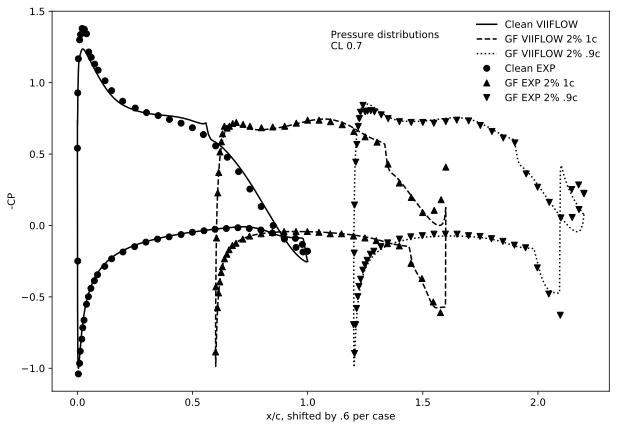

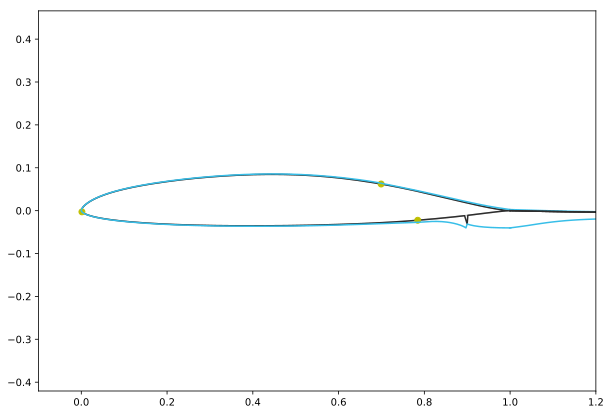

In [4]:
N = 260 #220 good for gfs/S903RF, 180 good for both, 280 good for both, too
AF = vft.repanel(vft.read_selig("S903RF.dat"),int(N),REFLIMS=[1.0,1.0,0.8,1.0],KAPFAC=.5,REFVAL=3,LEFAC=5,TEFAC = .5)

# Pressure comparison
hgv = [0.0,0.02,0.02]
pchord = [1,1,.9]
alphas = [4.5,0.08,1.5] # ->CL=0.7, read form above
lines = ['-','--',':']
shiftx = .6
shifty = 0

fig,ax = plt.subplots(1,1)
ax = [ax]
names = ['Clean VIIFLOW', 'GF VIIFLOW 2% 1c','GF VIIFLOW 2% .9c']
for k in range(len(hgv)):
    hg = hgv[k] 
    pc = pchord[k]
    alpha = alphas[k]
    
    vd = 0*AF[0,:]

    if pc>=1.0:
        index_gf = N-1
    else:
        for j in range(1,AF.shape[1]):
            if AF[0,-j]<pc:
                index_gf = N-j
                break
    vd[index_gf] = hg
    
    s.Alpha = alpha
    (p0,bl0,x0) = vf.init(AF,s)
    x0[p0.foils[0].N::p0.foils[0].N+p0.wakes[0].N-1]+=0.3
    if hg>0:
        xtrans = p0.foils[0].X[0,index_gf]-0.001
        vf.set_forced_transition(bl0,p0,[],[xtrans])
    [x,flag,res,grad,_] = vf.iter(x0,bl0,p0,s,None,None,[vd])

    ax[0].plot(p0.foils[0].X[0,:]+k*shiftx,-p0.cp[0:p0.foils[0].N]+k*shifty,label=names[k],color = colors[k],linestyle=lines[k])
    print(flag,p0.CL) # Print to check the CL ~.7

names = ['Clean EXP', 'GF EXP 2% 1c','GF EXP 2% .9c']
for k in range(3):
    Data = np.genfromtxt('S903GurneyCP.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[0].plot(Data.T[0]+k*shiftx,Data.T[1]+k*shifty,'o',color = colors[k],label = names[k],marker=marks[k])
ax[0].legend(frameon=False)
ax[0].set_xlabel('x/c, shifted by .6 per case')
ax[0].set_ylabel('-CP')
ax[0].text(.5,.9,'Pressure distributions\nCL 0.7',
        horizontalalignment='left',
        transform=ax[0].transAxes);

fig,ax = plt.subplots(1,1)
ax = [ax]
vfp.plot_geometry(ax[0],p0,bl0);

[1] Liu, Tianshu, and Javier Montefort. *Thin-airfoil theoretical interpretation for Gurney flap lift enhancement.* Journal of Aircraft 44.2 (2007): 667-671.

[2] Jeffrey, David, Xin Zhang, and David W. Hurst. *Aerodynamics of Gurney flaps on a single-element high-lift wing.* Journal of Aircraft 37.2 (2000): 295-301.

[3] Troolin, D. R., E. K. Longmire, and W. T. Lai. *Time resolved PIV analysis of flow over a NACA 0015 airfoil with Gurney flap.* Experiments in Fluids 41.2 (2006): 241-254.

[4] Coder, James George. *CFD Investigation of Unsteady Rotorcraft Airfoil Aerodynamics.* (2010).

[5] Storms, Bruce L., and Cory S. Jang. *Lift enhancement of an airfoil using a Gurney flap and vortex generators.* Journal of Aircraft 31.3 (1994): 542-547.

[6] Jeffrey, David, Xin Zhang, and David W. Hurst. *Aerodynamics of Gurney flaps on a single-element high-lift wing.* Journal of Aircraft 37.2 (2000): 295-301.

[7] Maughmer, Mark D., and Götz Bramesfeld. *Experimental investigation of Gurney flaps.* Journal of Aircraft 45.6 (2008): 2062-2067.

[8] Somers, Dan M. *Effects of Airfoil Thickness and Maximum Lift Coefficient on Roughness Sensitivity: 1997--1998.* No. NREL/SR-500-36336. National Renewable Energy Lab., Golden, CO (US), 2005.